#### Обучение трансформера:

#### Обучение и инференс моделей происходил на kaggle.com с использованием бесплатного недельного доступа к GPU блоку A100.

#### Загружаем недостающие модули:

In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install datasets accelerate nvidia-ml-py3

  Preparing metadata (setup.py) ... - done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19172 sha256=72b4b9ed9a29eb43e9c81bf22318b1639e0e704a99c94858b96e86ae59f05940
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3
Note: you may need to restart the kernel to use updated packages.


#### Импортируем модули:

In [1]:
import os
import string
import sys
import random
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import re
import datetime

import torch
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, random_split,  RandomSampler, SequentialSampler
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import summary, writer, SummaryWriter

from tqdm.notebook import tqdm


#### Устанавливаем Seed'ы:

In [4]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

import warnings
warnings.filterwarnings("ignore")

#### Задаём device:

In [5]:
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


#### Импортируем и устанавливаем дополнительно все, что необходимо:

In [6]:
!git clone https://github.com/KuzmaKhrabrov/character-tokenizer.git

Cloning into 'character-tokenizer'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 20 (delta 5), reused 10 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 5.89 KiB | 1.96 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [7]:
sys.path.append("/kaggle/input/tools/character-tokenizer")
from charactertokenizer import CharacterTokenizer

#### Check:

In [8]:
chars = "АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя-h"
model_max_length = 22
tokenizer = CharacterTokenizer(chars, model_max_length)

#### Проверяем Encode:

In [9]:
example = "-буh"
tokens = tokenizer(example)
print(tokens)

{'input_ids': [0, 73, 10, 48, 74, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}


#### Проверяем Decode:

In [10]:
print(tokenizer.decode(tokens["input_ids"]))

[CLS]-буh[SEP]


#### Задача:

##### Необходимо обучить модель классификации букв для задачи расстановки ударения с помощью методов из библиотеки transformers.

1. Написать класс для Dataset/Dataloder и разбить данные на случайные train / test сплиты в соотношении 50:50. (1 балл)
2. Попробовать обучить одну или несколько из моделей: Bert, Albert, Deberta. Посчитать метрику Accuracy на train и test. (1 балл). При преодолении порога в Accuracy на test 0.8: (+1 балл), 0.85: (+2 балла), 0.89: (+3 балла).

#### Датасет загружен, проверяем его содержимое:

In [11]:
accents_path = '/kaggle/input/accents-dataset/all_accents.tsv'
accents_dataset = pd.read_csv(accents_path, sep = '\t', header=0, encoding='utf-8', na_values='NA')

In [12]:
accents_dataset.head()

,-де,-д^е
0,-ка,-к^а
1,-либо,-л^ибо
2,-нибудь,-ниб^удь
3,-с,-с
4,-таки,-так^и


#### Немного исследований датасета:

In [13]:
# Число примеров:
print(accents_dataset.shape[0])

1680534


In [ ]:
# Символьная длина слов
def word_length(word):
    '''Просто принимаем на вход слово и возвращаем его длину'''
    return len(word)

# Один символ
def is_one_symbol(word):
    '''Возвращаем 1, если слово имеет один символ, иначе возвращаем 0'''
    return int(len(word) == 1)

# Больше одного слова через пробел
def more_than_one_word(word):
    '''Возвращаем 1, если несколько слов в записи, иначе 0'''
    splitted = word.split(' ')
    return int(len(splitted) > 1)

# Подсчет символов ударения ^:
def count_hat(word):
    '''Считаем количество символов ^'''
    return len(re.findall(r'\^', word))

# Есть ли латинские буквы в слове
def contains_latin(word):
    '''Обрабатываем случаи наличия латинских символов (bool flag)'''
    return int(bool(re.search(r'[a-zA-Z]', word)))

# Функция для подсчета символов, которые не являются русскими буквами
def count_non_russian(word):
    '''Считаем количество не кириллицы'''
    return len(re.findall(r'[a-zA-Z]', word))

def letter_yo(word):
    '''Обрабатываем случай буквы ёЁ, она всегда угарная'''
    return int(bool(re.search(r'[ёЁ]', word)))

def error_cases(word):
    '''Обработка ошибок (ударение в слове падает на согласную букву)'''
    pattern = r'\^[бвгджзйклмнпрстфхцчшщБВГДЖЗЙКЛМНПРСТФХЦЧШЩ]'   
    matches = re.findall(pattern, word)
    return len(matches)

# Последовательно обрабатываем датасет данными функциями для дальнейшего анализа
accents_dataset['word_length'] = accents_dataset['-де'].map(word_length)
accents_dataset['is_one_symbol'] = accents_dataset['-де'].map(is_one_symbol)
accents_dataset['more_than_one_word'] = accents_dataset['-де'].map(more_than_one_word)
accents_dataset['hat_num'] = accents_dataset['-д^е'].map(count_hat)
accents_dataset['has_latin'] = accents_dataset['-де'].map(contains_latin)
accents_dataset['num_non_russian'] = accents_dataset['-де'].map(count_non_russian)
accents_dataset['error_cases'] = accents_dataset['-д^е'].map(error_cases)
accents_dataset['is_Ёё'] = accents_dataset['-де'].map(letter_yo)

In [15]:
# Максимальное и среднее число символов в слове:
word_max_length = accents_dataset['word_length'].max()
print(f"Максимальное число символов в слове: {word_max_length}")

# Максимальное и среднее число символов в слове:
word_mean_length = accents_dataset['word_length'].mean()
print(f"Среднее число символов в слове: {word_mean_length}")

Максимальное число символов в слове: 56
Среднее число символов в слове: 10.641052189363618


#### Посмотрим более пристально на ударения:

In [16]:
accents_count_max = accents_dataset['hat_num'].max()
print(f"Максимальное число ударений в слове: {accents_count_max}")

zero_accents_num = accents_dataset[accents_dataset['hat_num'] == 0].shape[0]
print(f"Количество случаев отсутствия ударений в словах: {zero_accents_num}")

Максимальное число ударений в слове: 1
Количество случаев отсутствия ударений в словах: 507


Ошибок нет, где у нас больше одного ударения. Однако у нас целых 507 случаев отсутствия ударений в словах:

In [17]:
accents_dataset[accents_dataset['hat_num'] == 0].head(10)

,-де,-д^е,word_length,is_one_symbol,more_than_one_word,hat_num,has_latin,num_non_russian,error_cases,is_Ёё
3,-с,-с,2,0,0,0,0,0,0,0
16107,ай,ай,2,0,0,0,0,0,0,0
16172,айвингхо,айвингхо,8,0,0,0,0,0,0,0
24766,алмондсбери,алмондсбери,11,0,0,0,0,0,0,0
27255,ам,ам,2,0,0,0,0,0,0,0
29041,амка,амка,4,0,0,0,0,0,0,0
35185,анка,анка,4,0,0,0,0,0,0,0
42254,анька,анька,5,0,0,0,0,0,0,0
62526,б,б,1,1,0,0,0,0,0,0
75305,бедерный,бедерный,8,0,0,0,0,0,0,0


Возможно, это ошибка разметки или какие-то части слов. Но где-то это справедливо ввиду отсутствия гласных букв в словах. Подобные сэмплы могут запутать модель, но их количество в целом и незначительно в сравнении с общим числов сэмплов в обучении.

#### Нерусская раскладка:

In [18]:
accents_count_latin_max = accents_dataset['num_non_russian'].max()
print(f"Максимальное число нерусских символов в слове: {accents_count_latin_max}")

accents_count_latin = accents_dataset[accents_dataset['num_non_russian'] > 0].shape[0]
print(f"Количество сэмплов, где число нерусских символов больше 0: {accents_count_latin}")

Максимальное число нерусских символов в слове: 2
Количество сэмплов, где число нерусских символов больше 0: 14


In [19]:
accents_dataset[accents_dataset['num_non_russian'] > 0]

,-де,-д^е,word_length,is_one_symbol,more_than_one_word,hat_num,has_latin,num_non_russian,error_cases,is_Ёё
116704,буhалтер,буh^алтер,8,0,0,1,1,1,0,0
116705,буhалтер-калькулятор,буh^алтер-калькулятор,20,0,0,1,1,1,0,0
116706,буhалтер-ревизор,буh^алтер-ревизор,16,0,0,1,1,1,0,0
116707,буhалтерия,буhалт^ерия,10,0,0,1,1,1,0,0
116708,буhалтерски,буh^алтерски,11,0,0,1,1,1,0,0
116709,буhалтерский,буh^алтерский,12,0,0,1,1,1,0,0
116710,буhалтерша,буh^алтерша,10,0,0,1,1,1,0,0
620314,лимасcольский,лимасc^ольский,13,0,0,1,1,1,0,0
1018887,по-буhалтерски,по-буh^алтерски,14,0,0,1,1,1,0,0
1133176,прдjети,прдjети,7,0,0,0,1,1,0,0


Что ж, есть и такие сэмплы, но благо их тоже не очень-то и много.

#### Посмотрим на распределения слов по выделенным параметрам:

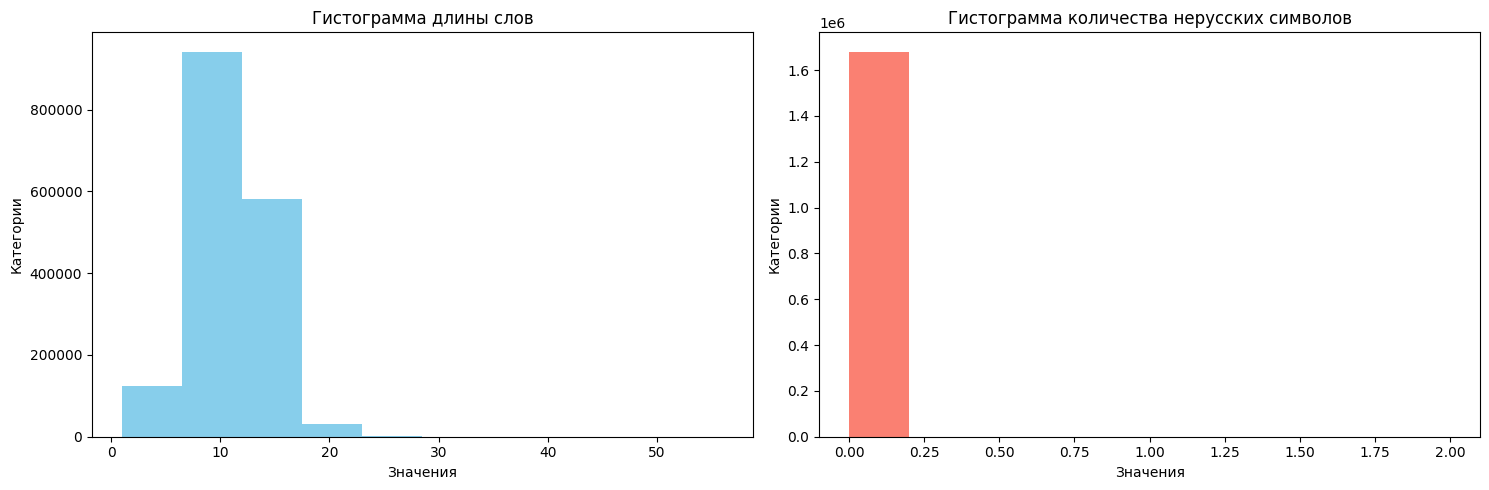

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(accents_dataset['word_length'], color='skyblue')
axs[0].set_title('Гистограмма длины слов')
axs[1].hist(accents_dataset['num_non_russian'], color='salmon')
axs[1].set_title('Гистограмма количества нерусских символов')
for ax in axs:
    ax.set_xlabel('Значения')
    ax.set_ylabel('Категории')

plt.tight_layout()
plt.show()

In [ ]:
# подсчет 95-% квантиля для распределения слов по длине
print(f"95-квантиль: {np.quantile(accents_dataset['word_length'].values, q = 0.95)}")

95-квантиль: 16.0


In [22]:
len(accents_dataset[accents_dataset['word_length'] > 20])

4477

Думаю 4500 длинных слов можно отбросить

In [23]:
accents_dataset = accents_dataset[accents_dataset['word_length'] < 20]

Итак, предварительный анализ показывает, что существуют особые сэмплы, которые могут повлиять на обобщающую способность модели. Однако их количество не такое уж и большое и, в целом, такие примеры как одна согласная могут быть довольно-таки полезными. По необходимости, отфильтруем данные позже.

Как вариант иностранные символы из латинской раскладки можно заменить транслитерацией на русские символы или, например, неизвестные символы (отличающиеся от "-") вообще убрать или заменить на другой символ. 

#### Еще хочется посмотреть, есть ли сэмплы, в которых случайно расставлены ударения на согласную букву и сэмплы, содержащие букву ёЁ, чтобы не учить модель на них:

In [24]:
print(f"Количество сэмплов с буквой Ёё: {accents_dataset[accents_dataset['is_Ёё'] != 0].shape[0]}")

print(f"Количество сэмплов с ударениям на согласную: {accents_dataset[accents_dataset['error_cases'] != 0].shape[0]}")

Количество сэмплов с буквой Ёё: 0
Количество сэмплов с ударениям на согласную: 0


Итак, букв Ёё и ошибок с ударением на согласную нет.

#### Всё же попробуем заменить английские символы транслитерацией:

In [ ]:
latin_to_russian_needed = {
    'c': 'с', 'h': 'г', 'j': 'ъ', 'g': 'г'
}

def transliterate(text):
    '''Делаем транслитерацию найденных латинских букв и символов'''
    return ''.join(latin_to_russian_needed.get(char, char) for char in text)

accents_dataset['words_upd'] = accents_dataset['-де'].map(transliterate)

In [26]:
accents_dataset[accents_dataset['num_non_russian'] > 0].head()

,-де,-д^е,word_length,is_one_symbol,more_than_one_word,hat_num,has_latin,num_non_russian,error_cases,is_Ёё,words_upd
116704,буhалтер,буh^алтер,8,0,0,1,1,1,0,0,бугалтер
116706,буhалтер-ревизор,буh^алтер-ревизор,16,0,0,1,1,1,0,0,бугалтер-ревизор
116707,буhалтерия,буhалт^ерия,10,0,0,1,1,1,0,0,бугалтерия
116708,буhалтерски,буh^алтерски,11,0,0,1,1,1,0,0,бугалтерски
116709,буhалтерский,буh^алтерский,12,0,0,1,1,1,0,0,бугалтерский


#### Уберем, где нет ударений все-таки:

In [27]:
accents_dataset = accents_dataset[accents_dataset['hat_num'] > 0]

#### Итоговый датасет после некоторых преобразований:

In [28]:
accents_dataset.shape

(1671254, 11)

In [29]:
accents_dataset.head(10)

,-де,-д^е,word_length,is_one_symbol,more_than_one_word,hat_num,has_latin,num_non_russian,error_cases,is_Ёё,words_upd
0,-ка,-к^а,3,0,0,1,0,0,0,0,-ка
1,-либо,-л^ибо,5,0,0,1,0,0,0,0,-либо
2,-нибудь,-ниб^удь,7,0,0,1,0,0,0,0,-нибудь
4,-таки,-так^и,5,0,0,1,0,0,0,0,-таки
5,-то,-т^о,3,0,0,1,0,0,0,0,-то
6,­вычеркнуть,­в^ычеркнуть,11,0,0,1,0,0,0,0,­вычеркнуть
7,а,^а,1,1,0,1,0,0,0,0,а
8,а-конто,а-к^онто,7,0,0,1,0,0,0,0,а-конто
9,а-ля,а-л^я,4,0,0,1,0,0,0,0,а-ля
10,а-мольный,а-м^ольный,9,0,0,1,0,0,0,0,а-мольный


#### Теперь нужно подготовить данные для обучения.

Предполагается, что есть смысл разделить слово на токены, причём каждая буква будет являться токеном. Далее можно присвоить каждому токену метку 1 или 0 в зависимости от того, является ли данный токен ударным или нет и выйти на своего рода задачу бинарной классификации для каждого токена.

UPD: позднее от данной идеи было решено отказаться в пользу классификации ударной позиции в слове. Посколько метка 1 одна, а меток 0 (безударная) может быть немало, модель может начать минимизировать лосс с приоритетом по безударным позициям, что не есть хорошо.

Однако посчитано и посчитано, перейти к задаче классификации не составит особого труда!

In [ ]:
def get_marked_dict(dataset = accents_dataset,
               input_column = 'words_upd',
               predict_column = '-д^е'):
    '''
	Функция, реализующая логику выделения ударного токена в слове
    
    Параметры:
    -dataset: выделенный датасет (default: accents_dataset)
    -input_column: колонка датасета, которую будем обрабатывать (default: 'words_upd')
    -predict_column: колонка датасета, где будем искать ударение (default: '-д^е')
    '''
    words = dataset[input_column].values
    words_accents = dataset[predict_column].values
    inputs = [word for word in words]
    labels = []
    
    for word, accents in tqdm(zip(words, words_accents)):
        label = [0] * (len(word) + 2)
        for i, char in enumerate(accents):
            if char == '^':
                label[i+1] = 1
                
        labels.append(label)
    return {"input_words" : inputs,
           "labels" : labels}
        
words_labels = get_marked_dict()

0it [00:00, ?it/s]

In [ ]:
def get_example(dict = words_labels,
                idx = 0):
    '''Получаем экземпляр после обработки'''
    print(words_labels['input_words'][idx], words_labels['labels'][idx])
    
get_example(idx = 1001)

абердинского [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
def convert_to_tokens(example):
    '''Конвертер экземпляра в токен'''
    result = tokenizer.convert_ids_to_tokens(example)
    return result

Вроде как размечено корректно. Создаем torch.utils.data.Dataset из словаря:

In [ ]:
class AccentDataset(Dataset):
    def __init__(self, words_labels = words_labels,
                 tokenizer = tokenizer,
                 max_len = 22):
        '''
        Конструктор датасета ударений, который мы и будем подавать в сеть
        
        Параметры:
        -self
        -words_labels: метки для ударности позиций (default: words_labels, полученные раннее)
        -tokenizer: токенизатор (default: tokenizer из репозитория)
        -max_len: ограничиваем максимальную длину слова (default: 22)
        '''
        self.data = words_labels
        self.tokenizer = tokenizer
        self.max_model_length = max_len
        
    def __len__(self):
        return len(self.data['input_words'])
    
    def __getitem__(self, idx, idx_to_token = False):
        input_word, accent_labels = self.data['input_words'][idx], self.data['labels'][idx]
        
        encoding = self.tokenizer.encode_plus(
            input_word,
            add_special_tokens=True,
            max_length=self.max_model_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        labels = torch.tensor(accent_labels, dtype=torch.long)
        padding_length = self.max_model_length - labels.size(0)
        idx = np.where(labels == 1)[0]
        if len(idx) == 0:
            print(input_ids)
            print(labels)
            print(convert_to_tokens(input_ids.tolist()))

        if idx_to_token == True:
            return {
                'input_ids': self.tokenizer.convert_ids_to_tokens(input_ids),
                'attention_mask': attention_mask,
                'labels': idx
                }
        return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'labels': idx
                }
    
    
words_labels_dataset = AccentDataset()

#### Check:

In [33]:
words_labels_dataset[168]['labels']

array([5])

In [34]:
len(words_labels_dataset)

1671254

In [35]:
words_labels_dataset[1001]

{'input_ids': tensor([ 0,  8, 10, 18, 42, 16, 26, 36, 44, 30, 38, 14, 38,  1,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': array([6])}

In [36]:
words_labels_dataset.__getitem__(0, idx_to_token = True)

{'input_ids': ['[CLS]',
  '-',
  'к',
  'а',
  '[SEP]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]'],
 'attention_mask': tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': array([3])}

Всё корректно. Теперь нужно написать функцию получения датасетов для train и для test.

In [ ]:
def get_datasets(dataset_cls = AccentDataset,
               max_len = 22, # 99+% слов ниже этой длины по символам
               data = words_labels,
               tokenizer = tokenizer,
               train_size = 0.5):
    '''
    Функция get_datasets() возвращает train и test датасеты на основе конструктора AccentDataset, делая train_test_spilt
    
    Параметры функции:
    -dataset_cls: класс датасета, который мы будем передвавать в функцию и чей конструктор мы будем вызывать (default: AccentDataset)
    -max_ken: максимальная длина последовательности токенов (решил взять 22, так как это 95% квантиль распределения слов по длинам)
    -data: данные (default: words_labels)
    -tokenizer: токенизатор (default: tokenizer)
    -train_size: размер train выборки для сплита (default: 0.5 из задания)
    '''
    
	# Вызов конструктора датасета
    dataset = dataset_cls(words_labels = data,
                 tokenizer = tokenizer,
                 max_len = max_len)
    
	# Устанавливаем размеры
    train_size = int(train_size * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
	# Возвращаем датасеты train + test
    return train_dataset, test_dataset

train_dataset_, test_dataset = get_datasets()
    

#### Check:

In [39]:
len(train_dataset_), len(test_dataset)

(835627, 835627)

#### Проверим тренировочный сэмпл:

In [40]:
train_dataset_[2]

{'input_ids': tensor([ 0, 24,  8, 40,  8, 52,  8, 36, 36, 48, 70,  1,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': array([4])}

In [41]:
print(convert_to_tokens(train_dataset_[2]['input_ids'].tolist()))

['[CLS]', 'з', 'а', 'п', 'а', 'х', 'а', 'н', 'н', 'у', 'ю', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [42]:
train_dataset_[2]['labels']

array([4])

#### Тестовый сэмпл:

In [43]:
test_dataset[2]

{'input_ids': tensor([ 0, 48, 54, 18, 40, 32, 72, 70, 46,  1,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': array([6])}

In [44]:
print(convert_to_tokens(test_dataset[2]['input_ids'].tolist()))

['[CLS]', 'у', 'ц', 'е', 'п', 'л', 'я', 'ю', 'т', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [45]:
test_dataset[2]['labels']

array([6])

Всё работает!

#### Теперь нужно сделать train_val_split:

In [ ]:
def train_val_split(dataset = train_dataset_,
				train_size = 0.9):
	
	'''
	Функция для создания искомого тренировочного и валидационного множества

	Параметры:
	-dataset: тренировочный датасет, который будет разбиваться на train x val (default: train_dataset_)
	-train_size: размер искомового тренировочного датасета от передаваемого (default: 0.9)
	'''
	
	# Объявляем размеры train x val
	train_size = int(train_size * len(dataset))
	val_size = len(dataset) - train_size
	
	# Делаем сплит и возвращаем тренировочный и тестовый датасеты
	train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
	return train_dataset, val_dataset

train_dataset, val_dataset = train_val_split()

#### Check:

In [47]:
len(train_dataset), len(val_dataset)

(752064, 83563)

In [48]:
train_dataset[2]['labels']

array([10])

In [ ]:
def get_loaders(train_dataset = train_dataset,
			val_dataset = val_dataset,
			test_dataset = test_dataset,
			shuffle_train = True,
			shuffle_val = False,
			shuffle_test = False,
			batch_size = 128):
	
	'''
	Функция get_loaders() для получения train, val и test даталоадеров

	Параметры:
	-train_dataset: тренировочный датасет (default: train_dataset)
	-val_dataset: валидационный датасет (default: val_dataset)
	-test_dataset: тестовый датасет (default: test_dataset)
	-shuffle_train: флаг перемешивания для train (default: True)
	-shuffle_val: флаг перемешивания для val (default: False)
	-shuffle_test: флаг перемешивания для test (default: False)
	-batch_size: размер батча данных (default: 128)
	'''
	
	# train_dataloader
	train_dataloader = DataLoader(
			train_dataset,   
			batch_size = batch_size,
			shuffle = shuffle_train,
		)

	# validation_dataloader
	validation_dataloader = DataLoader(
			val_dataset, 
			batch_size = batch_size,
			shuffle = shuffle_val,
		)
	
	# test_dataloader
	test_dataloader = DataLoader(
			test_dataset, 
			batch_size = batch_size,
			shuffle = shuffle_test,
		)
	
	# Возвращаем даталоадеры
	return train_dataloader, validation_dataloader, test_dataloader

train_dataloader, validation_dataloader, test_dataloader = get_loaders()


#### Check:

In [51]:
train_dataloader.dataset[0]

{'input_ids': tensor([ 0, 12, 18, 46, 18, 42, 26, 36,  8, 42, 36, 38, 34,  1,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': array([8])}

In [52]:
validation_dataloader.dataset[0]

{'input_ids': tensor([ 0, 42,  8, 44, 56, 18, 44, 64, 12,  8, 18, 34, 64,  1,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': array([2])}

#### Check итерирования:

In [53]:
for i, batch in enumerate(tqdm(train_dataloader)):
#     pass
    print(batch['input_ids'][0])
    print(len(batch['attention_mask'][0]))
    print(batch['labels'][0])
    print(convert_to_tokens(batch['input_ids'][0].tolist()))
    if i == 0:
        break

  0%|          | 0/5876 [00:00<?, ?it/s]

tensor([ 0, 40, 42, 26, 52, 32, 18, 44, 46, 36, 18, 46, 18,  1,  4,  4,  4,  4,
         4,  4,  4,  4])
22
tensor([10])
['[CLS]', 'п', 'р', 'и', 'х', 'л', 'е', 'с', 'т', 'н', 'е', 'т', 'е', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


#### Готовимся обучать...

In [ ]:
from transformers import BertForTokenClassification, BertForSequenceClassification, AdamW, get_scheduler

# Импортируем модель для классификации послеждовательностей
model = BertForSequenceClassification.from_pretrained(
    'DeepPavlov/rubert-base-cased',
    num_labels = 20 
)

# Перебрасываем модель на device
model.to('cuda' if torch.cuda.is_available() else 'cpu')


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

#### Тестируем прогон батчей через модель:

In [ ]:
model.eval()  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for i, batch in enumerate(train_dataloader):
    
    b_input_ids = batch['input_ids'].to(device)
    b_input_mask = batch['attention_mask'].to(device)
    b_labels = batch['labels']
    
	# Дополнительные выводы для проверки
#     print(f"{i}:")
#     print(b_input_ids.size())
#     print(b_input_mask.size())
#     print(b_labels)

    outputs = model(b_input_ids, attention_mask=b_input_mask)
    
    logits = outputs.logits
#     print(outputs.logits.size())
    
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.cpu().numpy()
    mask_ids = b_input_mask.cpu().numpy()
    
#     print(logits)
    
    pred_flat = np.argmax(logits, axis=-1).flatten()  
#     print(pred_flat)
    labels_flat = label_ids.flatten()  
    mask_flat = mask_ids.flatten() 
    
#     print(labels_flat)
    
    accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
    print(accuracy)
    

    if i == 10:
        break
    

0.0390625
0.0078125
0.03125
0.0234375
0.046875
0.03125
0.0390625
0.0234375
0.0078125
0.015625
0.0546875


Выводы работают!

#### Оптимизатор и его scheduler:

In [56]:
optimizer = AdamW(model.parameters(), lr=3e-5)

num_epochs = 15

train_steps = len(train_dataloader) * num_epochs
lr_scheduler = get_scheduler(
    name='linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=train_steps
)

#### Утилиты для train-val loop'а:

In [ ]:
def format_time(elapsed):
    '''Функция форматирования времени'''
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

def token_accuracy_for_accent(preds, labels, attention_mask):
    '''Функция подсчета accuracy для данных'''
    pred_flat = np.argmax(preds, axis=1).flatten()  
    labels_flat = labels.flatten()  
    mask_flat = attention_mask.flatten()  
    
    accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
    
	# Дополнительные выводы для контроля
#     if accuracy != 0:
#         print("Non-zero:")
#         print(pred_flat)
#         print(labels_flat)
    return accuracy


#### Функция тренировки модели:

In [ ]:
def train_model(
    model = model,
    train_dataloader = train_dataloader,
    validation_dataloader = validation_dataloader,
    optimizer = AdamW(model.parameters(), lr=3e-5),
    scheduler = lr_scheduler,
    num_epochs = 15,
    device = 'cuda',
    model_save_path = "bert_first_model.pth",
    tensorboard_log_dir = '/kaggle/working/runs/bert_launch',
    gradient_accumulation_steps=2,
    eval_every=1,
    test_batch_only=False
):
    '''
    Функция релиазации train_val loop
    
    Параметры:
    -model: модель (default: model)
    -train_dataloader: train даталоадер (default: train_dataloader)
    -validation_dataloader: val даталоадер (default: validation_dataloader)
    -optimizer: оптимизатор
    -scheduler: изменение для learning_rate
    -num_epochs: число эпох (default: 15)
    -device: device (default: 'cuda')
    -model_save_path: путь для сохранения весов (default: bert_first_model.pth)
    -tensorboard_loag_dir: путь для записи логов TensorBoard (default: /kaggle/working/runs/bert_launch)
    -gradient_accumulation_steps: число шагов для накопления градиентов (default: 2)
    -eval_every: число шагов, через которые делаем валидацию (default: 1)
    -test_batch_only: вспомогательная логика для тестирования обучения небольшого числа батчей (default: False)
    
    '''
    
    writer = SummaryWriter(log_dir=tensorboard_log_dir)
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
    best_val_accuracy = 0.0
    
    for epoch in range(num_epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_epochs))
        print('Training...')
        
        t0 = time.time()
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0
        num_train_steps = 0
        
        for step, batch in enumerate(tqdm(train_dataloader)):
            
            if test_batch_only and step >= 100:  # Прерываем после первого батча
                break
                
            
            if step % 1500 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input_ids = batch['input_ids'].to(device)
            b_input_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits
            
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()
            mask_ids = b_input_mask.cpu().numpy()
            
            batch_accuracy = token_accuracy_for_accent(logits, label_ids, mask_ids)
            
			# Дополнительная логика для контроля
#             if step == 0:
#                 print('Ground True:')
#                 print(label_ids.flatten())
#                 print("Predicted:")
#                 print(np.argmax(logits, axis=1).flatten())
#             print(batch_accuracy)
            total_train_accuracy += batch_accuracy

            total_train_loss += loss.item()
            num_train_steps += 1

            loss.backward()

            if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(train_dataloader):
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Клипаем накопленные градиенты
                optimizer.step()
                scheduler.step()
        
        avg_train_loss = total_train_loss / num_train_steps
        avg_train_accuracy = total_train_accuracy / num_train_steps
        
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))

        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(avg_train_accuracy)

        # Логирование в TensorBoard для обучения
        writer.add_scalar("Train/Loss", avg_train_loss, epoch + 1)
        writer.add_scalar("Train/Accuracy", avg_train_accuracy, epoch + 1)

        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
        
        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()
        
        if (epoch + 1) % eval_every == 0:
            model.eval()
            total_eval_loss = 0
            total_eval_accuracy = 0
            num_eval_steps = 0
        
        with torch.no_grad():
            for batch in validation_dataloader:
                
                if test_batch_only and num_eval_steps >= 100:  # Прерываем если хотим проконтроллировать
                    break
                b_input_ids = batch['input_ids'].to(device)
                b_input_mask = batch['attention_mask'].to(device)
                b_labels = batch['labels'].to(device)

                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits.detach().cpu().numpy()
                label_ids = b_labels.cpu().numpy()
                mask_ids = b_input_mask.cpu().numpy()

                batch_accuracy = token_accuracy_for_accent(logits, label_ids, mask_ids)
                total_eval_accuracy += batch_accuracy

                total_eval_loss += loss.item()
                num_eval_steps += 1

        avg_val_loss = total_eval_loss / num_eval_steps
        avg_val_accuracy = total_eval_accuracy / num_eval_steps

        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(avg_val_accuracy)

        # Логирование в TensorBoard для валидации
        writer.add_scalar("Validation/Loss", avg_val_loss, epoch + 1)
        writer.add_scalar("Validation/Accuracy", avg_val_accuracy, epoch + 1)

        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")

		# Если точность выше, то сохраняем веса
        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved to {model_save_path}")
    
    writer.close()
    return history

    

#### Обучаем модель:

In [59]:
train_model()


======== Epoch 1 / 15 ========
Training...


  0%|          | 0/5876 [00:00<?, ?it/s]

  Batch 1,500  of  5,876.    Elapsed: 0:06:52.
  Batch 3,000  of  5,876.    Elapsed: 0:13:43.
  Batch 4,500  of  5,876.    Elapsed: 0:20:33.

  Average training loss: 0.88
  Training epoch took: 0:26:50
Train Loss: 0.8769, Train Accuracy: 0.6771

Running Validation...
Validation Loss: 0.5081, Validation Accuracy: 0.8003
Model saved to bert_first_model.pth

======== Epoch 2 / 15 ========
Training...


  0%|          | 0/5876 [00:00<?, ?it/s]

  Batch 1,500  of  5,876.    Elapsed: 0:06:51.
  Batch 3,000  of  5,876.    Elapsed: 0:13:43.
  Batch 4,500  of  5,876.    Elapsed: 0:20:35.

  Average training loss: 0.46
  Training epoch took: 0:26:53
Train Loss: 0.4630, Train Accuracy: 0.8183

Running Validation...
Validation Loss: 0.3748, Validation Accuracy: 0.8548
Model saved to bert_first_model.pth

======== Epoch 3 / 15 ========
Training...


  0%|          | 0/5876 [00:00<?, ?it/s]

  Batch 1,500  of  5,876.    Elapsed: 0:06:51.
  Batch 3,000  of  5,876.    Elapsed: 0:13:43.
  Batch 4,500  of  5,876.    Elapsed: 0:20:34.

  Average training loss: 0.37
  Training epoch took: 0:26:52
Train Loss: 0.3668, Train Accuracy: 0.8580

Running Validation...
Validation Loss: 0.3030, Validation Accuracy: 0.8858
Model saved to bert_first_model.pth

======== Epoch 4 / 15 ========
Training...


  0%|          | 0/5876 [00:00<?, ?it/s]

  Batch 1,500  of  5,876.    Elapsed: 0:06:52.
  Batch 3,000  of  5,876.    Elapsed: 0:13:43.
  Batch 4,500  of  5,876.    Elapsed: 0:20:34.

  Average training loss: 0.30
  Training epoch took: 0:26:51
Train Loss: 0.3042, Train Accuracy: 0.8840

Running Validation...
Validation Loss: 0.2563, Validation Accuracy: 0.9074
Model saved to bert_first_model.pth

======== Epoch 5 / 15 ========
Training...


  0%|          | 0/5876 [00:00<?, ?it/s]

  Batch 1,500  of  5,876.    Elapsed: 0:06:52.
  Batch 3,000  of  5,876.    Elapsed: 0:13:43.
  Batch 4,500  of  5,876.    Elapsed: 0:20:34.

  Average training loss: 0.26
  Training epoch took: 0:26:51
Train Loss: 0.2603, Train Accuracy: 0.9011

Running Validation...
Validation Loss: 0.2262, Validation Accuracy: 0.9177
Model saved to bert_first_model.pth

======== Epoch 6 / 15 ========
Training...


  0%|          | 0/5876 [00:00<?, ?it/s]

  Batch 1,500  of  5,876.    Elapsed: 0:06:51.
  Batch 3,000  of  5,876.    Elapsed: 0:13:42.
  Batch 4,500  of  5,876.    Elapsed: 0:20:34.

  Average training loss: 0.23
  Training epoch took: 0:26:51
Train Loss: 0.2295, Train Accuracy: 0.9140

Running Validation...
Validation Loss: 0.2092, Validation Accuracy: 0.9245
Model saved to bert_first_model.pth

======== Epoch 7 / 15 ========
Training...


  0%|          | 0/5876 [00:00<?, ?it/s]

  Batch 1,500  of  5,876.    Elapsed: 0:06:52.
  Batch 3,000  of  5,876.    Elapsed: 0:13:43.
  Batch 4,500  of  5,876.    Elapsed: 0:20:35.

  Average training loss: 0.21
  Training epoch took: 0:26:52
Train Loss: 0.2057, Train Accuracy: 0.9234

Running Validation...
Validation Loss: 0.1897, Validation Accuracy: 0.9329
Model saved to bert_first_model.pth

======== Epoch 8 / 15 ========
Training...


  0%|          | 0/5876 [00:00<?, ?it/s]

  Batch 1,500  of  5,876.    Elapsed: 0:06:51.
  Batch 3,000  of  5,876.    Elapsed: 0:13:42.
  Batch 4,500  of  5,876.    Elapsed: 0:20:33.

  Average training loss: 0.19
  Training epoch took: 0:26:51
Train Loss: 0.1862, Train Accuracy: 0.9307

Running Validation...
Validation Loss: 0.1730, Validation Accuracy: 0.9389
Model saved to bert_first_model.pth

======== Epoch 9 / 15 ========
Training...


  0%|          | 0/5876 [00:00<?, ?it/s]

  Batch 1,500  of  5,876.    Elapsed: 0:06:51.
  Batch 3,000  of  5,876.    Elapsed: 0:13:43.
  Batch 4,500  of  5,876.    Elapsed: 0:20:34.

  Average training loss: 0.17
  Training epoch took: 0:26:52
Train Loss: 0.1708, Train Accuracy: 0.9376

Running Validation...
Validation Loss: 0.1696, Validation Accuracy: 0.9424
Model saved to bert_first_model.pth

======== Epoch 10 / 15 ========
Training...


  0%|          | 0/5876 [00:00<?, ?it/s]

  Batch 1,500  of  5,876.    Elapsed: 0:06:51.
  Batch 3,000  of  5,876.    Elapsed: 0:13:42.
  Batch 4,500  of  5,876.    Elapsed: 0:20:33.

  Average training loss: 0.16
  Training epoch took: 0:26:51
Train Loss: 0.1568, Train Accuracy: 0.9422

Running Validation...
Validation Loss: 0.1665, Validation Accuracy: 0.9432
Model saved to bert_first_model.pth

======== Epoch 11 / 15 ========
Training...


  0%|          | 0/5876 [00:00<?, ?it/s]

  Batch 1,500  of  5,876.    Elapsed: 0:06:51.
  Batch 3,000  of  5,876.    Elapsed: 0:13:42.
  Batch 4,500  of  5,876.    Elapsed: 0:20:33.

  Average training loss: 0.15
  Training epoch took: 0:26:49
Train Loss: 0.1457, Train Accuracy: 0.9470

Running Validation...
Validation Loss: 0.1534, Validation Accuracy: 0.9480
Model saved to bert_first_model.pth

======== Epoch 12 / 15 ========
Training...


  0%|          | 0/5876 [00:00<?, ?it/s]

  Batch 1,500  of  5,876.    Elapsed: 0:06:52.
  Batch 3,000  of  5,876.    Elapsed: 0:13:42.
  Batch 4,500  of  5,876.    Elapsed: 0:20:33.

  Average training loss: 0.14
  Training epoch took: 0:26:51
Train Loss: 0.1362, Train Accuracy: 0.9504

Running Validation...
Validation Loss: 0.1524, Validation Accuracy: 0.9501
Model saved to bert_first_model.pth

======== Epoch 13 / 15 ========
Training...


  0%|          | 0/5876 [00:00<?, ?it/s]

  Batch 1,500  of  5,876.    Elapsed: 0:06:52.
  Batch 3,000  of  5,876.    Elapsed: 0:13:43.
  Batch 4,500  of  5,876.    Elapsed: 0:20:35.

  Average training loss: 0.13
  Training epoch took: 0:26:51
Train Loss: 0.1274, Train Accuracy: 0.9540

Running Validation...
Validation Loss: 0.1458, Validation Accuracy: 0.9534
Model saved to bert_first_model.pth

======== Epoch 14 / 15 ========
Training...


  0%|          | 0/5876 [00:00<?, ?it/s]

  Batch 1,500  of  5,876.    Elapsed: 0:06:50.
  Batch 3,000  of  5,876.    Elapsed: 0:13:40.
  Batch 4,500  of  5,876.    Elapsed: 0:20:30.

  Average training loss: 0.12
  Training epoch took: 0:26:46
Train Loss: 0.1197, Train Accuracy: 0.9570

Running Validation...
Validation Loss: 0.1403, Validation Accuracy: 0.9539
Model saved to bert_first_model.pth

======== Epoch 15 / 15 ========
Training...


  0%|          | 0/5876 [00:00<?, ?it/s]

  Batch 1,500  of  5,876.    Elapsed: 0:06:50.
  Batch 3,000  of  5,876.    Elapsed: 0:13:41.
  Batch 4,500  of  5,876.    Elapsed: 0:20:31.

  Average training loss: 0.11
  Training epoch took: 0:26:49
Train Loss: 0.1131, Train Accuracy: 0.9594

Running Validation...
Validation Loss: 0.1446, Validation Accuracy: 0.9537


{'train_loss': [0.876900054123874,
  0.46296373213570974,
  0.3668143760217664,
  0.30419622650883527,
  0.2602912243988195,
  0.22947682055706187,
  0.20574887540670703,
  0.18621264057204767,
  0.17079273843852494,
  0.15683323101833505,
  0.1456601994458923,
  0.13624546970028387,
  0.12743466424389943,
  0.1197461914800493,
  0.1131410279298243],
 'train_accuracy': [0.6771400612661674,
  0.818306192562968,
  0.8580387912695712,
  0.8840396847345132,
  0.9011391678012253,
  0.914015965367597,
  0.9234079837474473,
  0.9307471600578625,
  0.9375717962899932,
  0.9421680884104833,
  0.9469531781824371,
  0.9504299800034037,
  0.9539958624063989,
  0.9569727493192648,
  0.9593872319605173],
 'val_loss': [0.5080552857374889,
  0.37476879648099815,
  0.3030033187104951,
  0.25631631460114973,
  0.2261767920226452,
  0.2092050154269837,
  0.18970939684174326,
  0.1730257809207779,
  0.16961635209357573,
  0.1665090957961714,
  0.15337540819716125,
  0.15243475808894652,
  0.14578738592987

#### Графики обучения в TensorBoard:

<img src="transformer_training_logs.png" alt="Example Image" width="650" height="650">